In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
#from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.io import arff

import sys
import importlib
sys.path.append('../../helpers/')
import helper
sys.path.append('../../model/')
from ourModel import Classifier, train, test

In [3]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [4]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    # Get the name of the current GPU (device 0 in this example)
    current_gpu_name = torch.cuda.get_device_name(0)

    print(f"Number of GPUs available: {num_gpus}")
    print(f"Current GPU name: {current_gpu_name}")
else:
    print("CUDA is not available. Running on CPU.")


Number of GPUs available: 1
Current GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


# Prepare Dataset 

Load Dataset

In [3]:
data_file_path = '../../datasets/higgs/Higgs.arff'
df = arff.loadarff(data_file_path)
df = pd.DataFrame(df[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98050 entries, 0 to 98049
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   class                     98050 non-null  float64
 1   lepton_pT                 98050 non-null  float64
 2   lepton_eta                98050 non-null  float64
 3   lepton_phi                98050 non-null  float64
 4   missing_energy_magnitude  98050 non-null  float64
 5   missing_energy_phi        98050 non-null  float64
 6   jet1pt                    98050 non-null  float64
 7   jet1eta                   98050 non-null  float64
 8   jet1phi                   98050 non-null  float64
 9   jet1b-tag                 98050 non-null  float64
 10  jet2pt                    98050 non-null  float64
 11  jet2eta                   98050 non-null  float64
 12  jet2phi                   98050 non-null  float64
 13  jet2b-tag                 98050 non-null  float64
 14  jet3pt

Clean Data

In [4]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
df.head()

,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [5]:
targets = [
    'class'
]

for x in targets:
    print(df[x].value_counts())


1.0    51826
0.0    46223
Name: class, dtype: int64


In [7]:
# encode the labels of the targets and create decoding dict
label_encoders = []
encoded_to_labels = []
for x in range(len(targets)):
    label_encoders.append(LabelEncoder())
    df[targets[x]] = label_encoders[x].fit_transform(df[targets[x]])
    encoded_to_labels.append({encoded: label for label, encoded in zip(label_encoders[x].classes_, label_encoders[x].transform(label_encoders[x].classes_))})



In [8]:
for x in targets:
    print(df[x].value_counts())
print(encoded_to_labels)

1    51826
0    46223
Name: class, dtype: int64
[{0: 0.0, 1: 1.0}]


# Beyond here you dont have to mess with the dataframe anymore.

### Structure data for pytorch and split into training and testing splits

In [9]:
# dataset wrapper for the dataframe. Just a way to structure the data that pytorch likes and needs to then wrap with dataloader.

class DatasetWrapper(Dataset):
    def __init__(self, df : pd.DataFrame, target : str):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=targets)).astype(np.float32)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
exp_dataset = DatasetWrapper(df, target=targets) # UPDATE for your experiments

# Split training and testing samples
train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 256 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 78439, Test length: 19610


## Model instantiation

In [10]:
num_features =  len(train_dataset[0][0])
num_targets =   len(train_dataset[0][1])
classes_per_target = [len(df[t].unique()) for t in targets ]

print(f"Features: {num_features}")
print(f"Targets: {num_targets}")
print(f"Classes per Target: {classes_per_target}")

Features: 28
Targets: 1
Classes per Target: [2]


In [11]:
#Updated with f1
model = Classifier(n_features=num_features, 
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=2, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model


## Loss functions

In [12]:
loss_functions = []
#This loop could easily be adapted to us BinaryCrossEntropy for binary class and Cross for multi class
for x in targets:
    loss_functions.append(nn.CrossEntropyLoss())

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


## Train Test Loop

In [13]:
epochs = 40 #Set the number of epochs

In [14]:
train_losses = []
test_losses = []
train_accuracies = [[] for _ in range(num_targets)]
test_accuracies =  [[] for _ in range(num_targets)]

for t in range(epochs):
  train_loss, train_accuracy= train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, all_predictions, all_targets, f1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  #Losses
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  #Accuracies
  for i in range(num_targets):
    train_accuracies[i].append(train_accuracy[i])
    test_accuracies[i].append(test_accuracy[i])
 
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"

  train_metrics = f"Train: Loss {train_loss:.2f}"
  for target, Acc in zip(targets, train_accuracy):
    train_metrics += f", {target} Accuracy: {Acc:.2f}"
  
  test_metrics = f"Test: Loss {test_loss:.2f}"
  for target, Acc, fone in zip(targets, test_accuracy, f1):
    test_metrics += f", {target} Accuracy: {Acc:.2f}, {target} F1: {fone:.2f}"

  print(f"{epoch_str:15} | {train_metrics} | {test_metrics}")


Epoch [ 1/40]   | Train: Loss 0.65, class Accuracy: 0.61 | Test: Loss 0.61, class Accuracy: 0.66, class F1: 0.66
Epoch [ 2/40]   | Train: Loss 0.60, class Accuracy: 0.67 | Test: Loss 0.60, class Accuracy: 0.67, class F1: 0.67
Epoch [ 3/40]   | Train: Loss 0.59, class Accuracy: 0.68 | Test: Loss 0.59, class Accuracy: 0.68, class F1: 0.68
Epoch [ 4/40]   | Train: Loss 0.59, class Accuracy: 0.68 | Test: Loss 0.59, class Accuracy: 0.68, class F1: 0.68
Epoch [ 5/40]   | Train: Loss 0.58, class Accuracy: 0.68 | Test: Loss 0.58, class Accuracy: 0.68, class F1: 0.68
Epoch [ 6/40]   | Train: Loss 0.58, class Accuracy: 0.68 | Test: Loss 0.58, class Accuracy: 0.68, class F1: 0.68
Epoch [ 7/40]   | Train: Loss 0.58, class Accuracy: 0.68 | Test: Loss 0.58, class Accuracy: 0.68, class F1: 0.68
Epoch [ 8/40]   | Train: Loss 0.58, class Accuracy: 0.68 | Test: Loss 0.58, class Accuracy: 0.68, class F1: 0.68
Epoch [ 9/40]   | Train: Loss 0.58, class Accuracy: 0.69 | Test: Loss 0.58, class Accuracy: 0.68

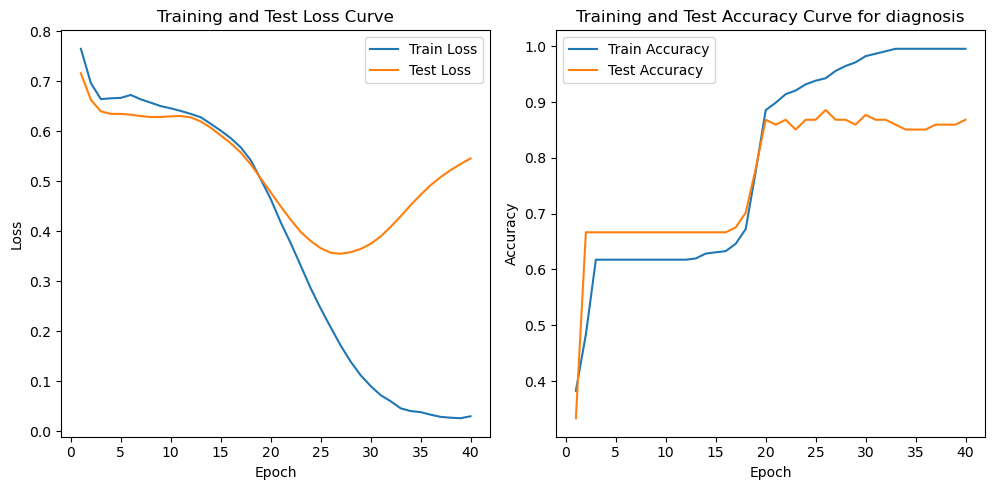

In [15]:
plot_num = 1
# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, plot_num)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plot_num+=1

for i in range(num_targets):
    plt.subplot(1, 3, plot_num)
    plt.plot(range(1, epochs+1), train_accuracies[i], label='Train Accuracy')
    plt.plot(range(1, epochs+1), test_accuracies[i], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy Curve for {targets[i]}')
    plt.legend()
    plot_num+=1


plt.tight_layout()
plt.tight_layout()
plt.show()


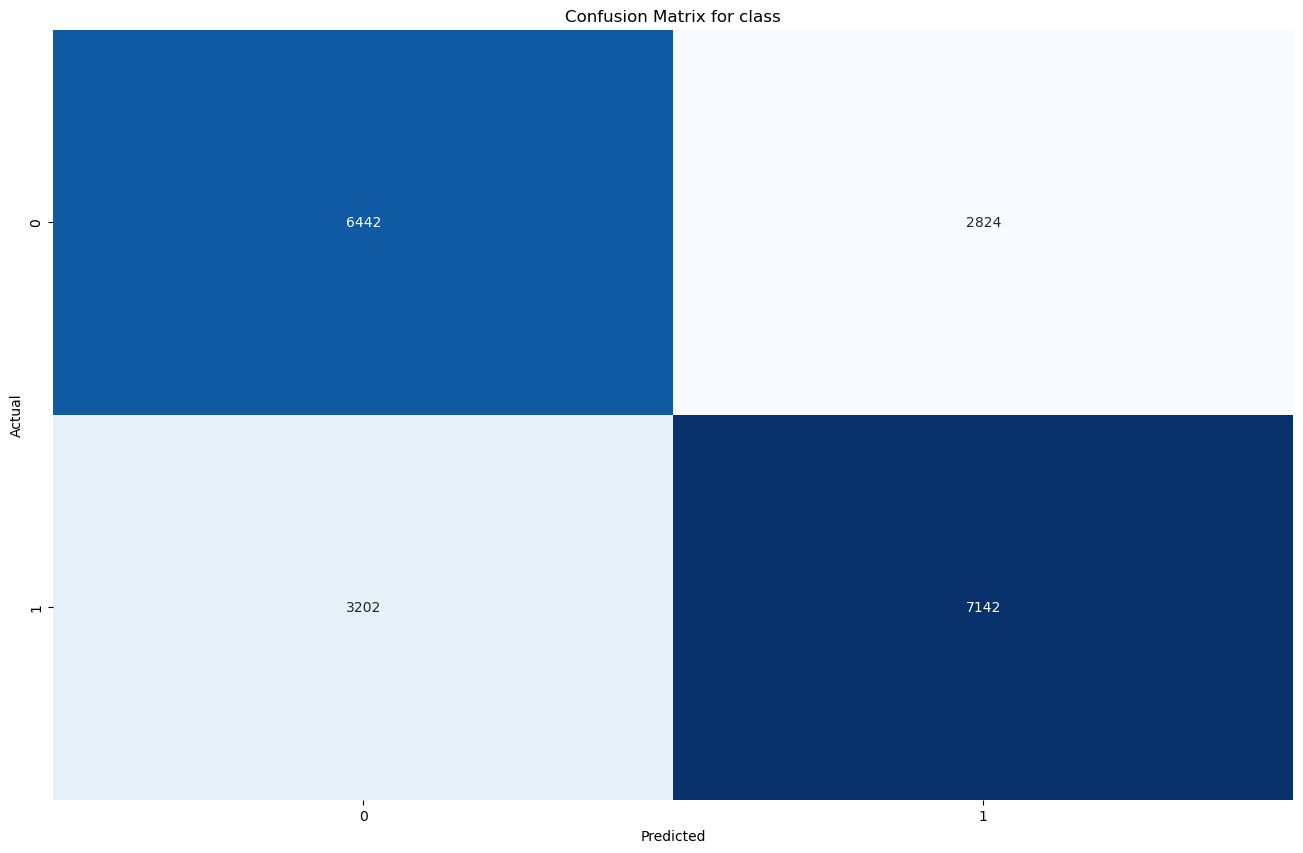

In [15]:
conf_matrix = confusion_matrix(all_targets[0], all_predictions[0])
plt.figure(figsize=(16, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {targets[0]}')
plt.show()